In [1]:
%reload_ext autoreload
%autoreload 2
import observer as obs
import generator as gen
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from matplotlib import rc

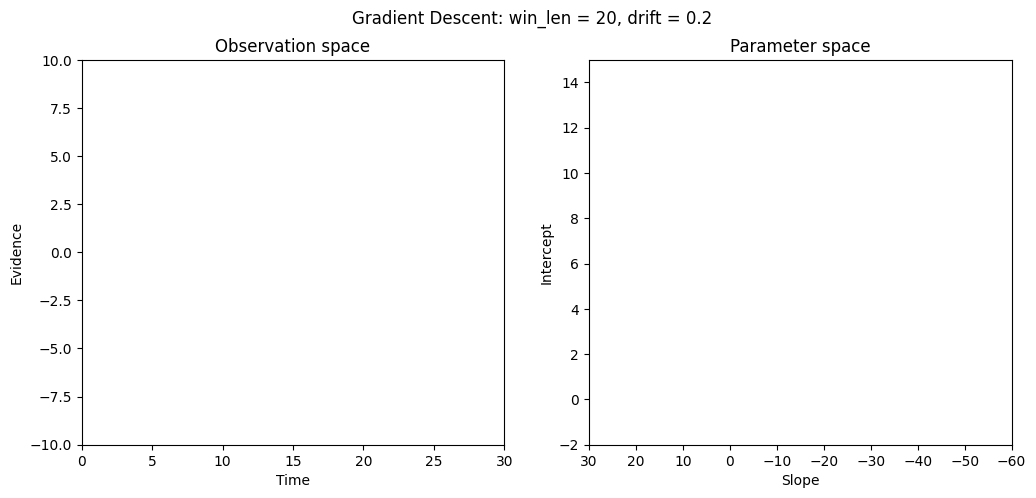

In [2]:
# Initialize all the figure elements for animation
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1) # Two subplots: first one shows walks
ax2 = plt.subplot(1,2,2) # second one shows navigation on reward landscape
obs_params = obs.get_gen_params()
gen_params = gen.get_params()
if obs_params['update_method'] == 'grad':
    plt.suptitle('Gradient Descent: win_len = {}, drift = {}'.format(obs_params['win_len'], gen_params['eps']))
elif obs_params['update_method'] == 'greedy':
    plt.suptitle('Epsilon Greedy: win_len = {}, drift = {}, eps = {}'.format(obs_params['win_len'], gen_params['eps'], obs_params['greedy_eps']))

ax1.set_xlim((0, 30))
ax1.set_ylim((-10, 10))
ax1.set_xlabel('Time')
ax1.set_ylabel('Evidence')
ax1.set_title('Observation space')

ax2.set_xlim((30, -60))
ax2.set_ylim((-2, 15))
ax2.set_xlabel('Slope')
ax2.set_ylabel('Intercept')
ax2.set_title('Parameter space')
rr_text = ax2.text(0.82, 0.95, '', transform=ax2.transAxes)

pos_thresh, = ax1.plot([], [], 'k', lw=2) # This line will show the upper threshold (updated at each iteration)
neg_thresh, = ax1.plot([], [], 'k', lw=2) # lower threshold
walk_lines = [] # list of walks during each estimation window
decision_pts = [] # the decisions (in evidence-time space) for each walk are also plotted
for ii in range(obs.get_window_len()):
    walk_lines_ii, = ax1.plot([], [], '#7f7f7f', lw=0.5)
    decision_pts_ii, = ax1.plot([], [], 'g.', ms=20)
    walk_lines.append(walk_lines_ii) # add each walk to the list
    decision_pts.append(decision_pts_ii)

curr_bound, = ax2.plot([], [], 'r.', ms=20)
traj_x = []
traj_y = []
bound_traj, = ax2.plot([], [], '#ff000080', lw=0.7)


def draw_frame(update, prev_bound):
    ''' This function updates various plot elements during each frame's drawing

        update = list of parameter values (gradient, bound, ...) that are updated
        prev_bound = (slope, intercept) at previous iteration
    '''
    # grad = update[0]
    # del_slope = grad[0]
    # del_inter = grad[1]
    new_bound = update[0]
    walks = update[1]
    decisions = update[2]
    true_states = update[3]
    rr = update[4]

    ### Hack: because logic for which walks to show for update slightly different for greedy and grad methods
    if obs.get_gen_params()['update_method'] == 'grad':
        use_bound = prev_bound
    else:
        use_bound = new_bound

    ### Plot thresholds and walks
    xvals = np.arange(0, 30)
    yvals = obs.compute_thresh_time(use_bound, max_step=30)
    thresh_zero = np.where(yvals < 0)[0] # indices where threshold below x-axis
    if thresh_zero.size != 0: # threshold does cross x-axis
        xvals = xvals[0:thresh_zero[0]] # don't draw threshold beyond where it crosses x-axis
        yvals = yvals[0:thresh_zero[0]]
    pos_thresh.set_data(xvals, yvals) # upper bound
    neg_thresh.set_data(xvals, -1*yvals) # lower bound
    for ii in range(obs.get_window_len()):
        yvals_ii = walks[ii]
        xvals_ii = np.arange(0, len(yvals_ii))
        walk_lines[ii].set_data(xvals_ii, yvals_ii)
        if decisions[ii] == true_states[ii]:
            decision_pts[ii].set_data(len(walks[ii])-1, walks[ii][-1])
            decision_pts[ii].set_color('#00ff0060')
        else:
            decision_pts[ii].set_data(len(walks[ii])-1, walks[ii][-1])
            decision_pts[ii].set_color('#ff000060')

    ### Plot current bound in parameter space
    curr_bound.set_data(use_bound[0], use_bound[1])
    traj_x.append(use_bound[0])
    traj_y.append(use_bound[1])
    bound_traj.set_data(traj_x, traj_y)
    rr_text.set_text('RR = {0:.2f}'.format(rr))
    


def animate(frame_num):
    ''' This function is called on each frame update
    '''
    global prev_bound # use the global variable as this variable will be updated at each frame
    global rr_seq # memory of RRs experienced - global as need to be added to at each iteration

    update = obs.update_bound(prev_bound, rr_seq) # update the bound based on update algorightm (e.g. gradient descent)
    draw_frame(update, prev_bound)
    prev_bound = update[0] # update[0] = new_bound
    if obs.get_gen_params()['update_method'] == 'greedy':
        rr_seq = update[-1]
        # print('rr_seq = {}, avg = {}\n'.format(rr_seq, sum(rr_seq)/len(rr_seq)))
    return (walk_lines, decision_pts)


In [3]:
### Create the animation
params = obs.get_gen_params()
ibound = params['init_bound']
prev_bound = ibound # initialise the value of the bound - Note: this is a global variable that will be iteratively updated
rr_seq = [] # a list of RRs experienced at current location - used by eps_Greedy
anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
anim.save('policy_animation.mp4', fps=4, extra_args=['-vcodec', 'libx264'])
